In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

2024-08-03 16:38:11.953724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 16:38:11.953787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 16:38:11.955080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 16:38:11.962487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 16:38:13.244843: W tensorflow/compiler/tf2

In [2]:
audio_binary=tf.io.read_file("/mnt/c/Users/Lenovo/Desktop/DS/Datasets/LJSpeech-1.1/wavs/LJ001-0001.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(212893,)


2024-08-03 16:38:15.612747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 16:38:15.669104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 16:38:15.669180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 16:38:15.674818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 16:38:15.674922: I external/local_xla/xla/stream_executor

2024-08-03 16:38:16.326425: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(212893,)


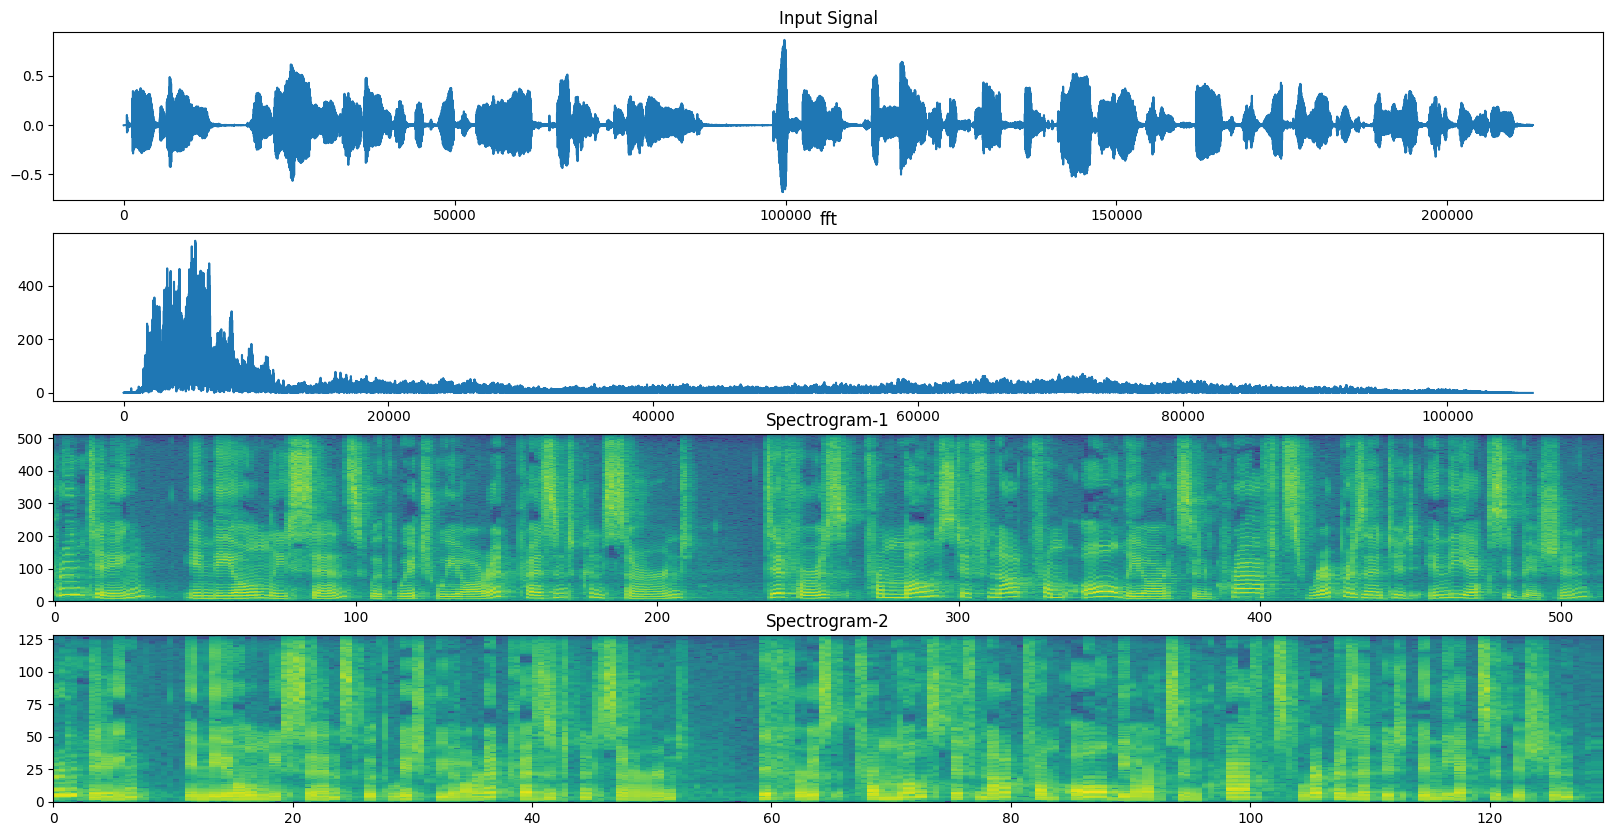

In [3]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [4]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

## Data preperation

In [5]:
audio_text={}

In [6]:
csv_path="/mnt/c/Users/Lenovo/Desktop/DS/Datasets/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0]
    text=line.strip().split("|")[1]
    audio_text[str(i)]=text

In [22]:
filepaths=["/mnt/c/Users/Lenovo/Desktop/DS/Datasets/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text.keys())]
transcriptions=[audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [23]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

In [24]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [25]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [26]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [27]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [28]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [29]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [30]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

## Modeling

In [31]:
normalization=tf.keras.layers.Normalization()

In [32]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization_1 (Normaliza  (None, None, 129, 1)      3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, None, 65, 32)      14464     
                                                                 
 layer_normalization_2 (Lay  (None, None, 65, 32)      64        
 erNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_3 (Lay  (None, None, 33,

In [33]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [34]:
checkpoint_filepath = '/mnt/c/Users/Lenovo/Desktop/DS/Datasets/Outputs/SpeechRecog.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [38]:
history=model.fit(
  train_dataset.take(128),
  validation_data=val_dataset,
  verbose=1,
  epochs=1
)

128/128 [==============================] - 2107s 17s/step - loss: 451.4031 - val_loss: 392.8752


## Testing

In [39]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [40]:
test_path="/mnt/c/Users/Lenovo/Desktop/DS/Datasets/LJSpeech-1.1/wavs/LJ001-0005.wav"

In [41]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

(1396, 129, 1)
1/1 [==============================] - 2s 2s/step


In [42]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)

In [43]:
print(out_str)

h                iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]iiiiiiiiiiiiiiiiiiiii

In [44]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [45]:
print(decode(tf.expand_dims(out,axis=0)))

tf.Tensor([  1 698], shape=(2,), dtype=int32)
h iii                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
